### Setup

In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import style
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
style.use("ggplot")

/usr/local/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Loading Dataset and Randomization

In [2]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


### Preprocess Data

In [3]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]
    ]
    preprocessed_features = selected_features.copy()
    preprocessed_features["rooms_per_person"] = (california_housing_dataframe["total_rooms"]/
                                                 california_housing_dataframe["population"])
    return preprocessed_features

def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    output_targets["median_house_value_is_high"] = (
        california_housing_dataframe["median_house_value"] > 265000).astype(float) # binary values
    return output_targets

### Training set and Validation set

In [4]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

print("Training Examples Summary: ")
display.display(training_examples.describe())
print("Validation Examples Summary: ")
display.display(validation_examples.describe())
print("Training Targets Summary: ")
display.display(training_targets.describe())
print("Validation Targets Summary: ")
display.display(validation_targets.describe())

Training Examples Summary: 


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2636.6,539.9,1425.4,501.2,3.9,2.0
std,2.1,2.0,12.6,2169.2,423.8,1122.8,385.7,1.9,1.3
min,32.5,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1465.0,298.0,793.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2129.0,434.0,1165.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3124.0,649.0,1723.0,603.0,4.7,2.3
max,42.0,-114.6,52.0,37937.0,6445.0,28566.0,6082.0,15.0,55.2


Validation Examples Summary: 


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.7,2660.6,538.1,1439.5,501.2,3.9,2.0
std,2.1,2.0,12.5,2205.8,415.9,1206.0,381.7,1.9,0.9
min,32.5,-124.3,1.0,2.0,2.0,6.0,2.0,0.5,0.2
25%,33.9,-121.8,18.0,1451.0,294.0,782.0,279.0,2.6,1.5
50%,34.3,-118.5,29.0,2122.0,433.0,1174.0,409.0,3.6,2.0
75%,37.7,-118.0,37.0,3192.0,648.0,1716.2,608.0,4.8,2.3
max,41.9,-114.3,52.0,30405.0,4819.0,35682.0,4769.0,15.0,26.5


Training Targets Summary: 


,median_house_value_is_high
count,12000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Validation Targets Summary: 


,median_house_value_is_high
count,5000.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


### Construct Features Columns

In [5]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_features)
                for my_features in input_features])

### Input Function

In [6]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(value) for key, value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Train Linear Regression Model

In [7]:
def train_linear_regressor_model(learning_rate,
                                 steps,
                                 batch_size,
                                 training_examples,
                                 training_targets,
                                 validation_examples,
                                 validation_targets):
    periods = 10
    steps_per_period = steps / periods
    
    # Create linear_regressor object
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns = construct_feature_columns(training_examples),
        optimizer = my_optimizer
    )
    
    # Create input functions
    training_input_fn = lambda: my_input_fn(training_examples,
                                            training_targets["median_house_value_is_high"],
                                            batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples,
                                                    training_targets["median_house_value_is_high"],
                                                    shuffle=False,
                                                    num_epochs=1)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                                      validation_targets["median_house_value_is_high"],
                                                      shuffle=False,
                                                      num_epochs=1)
    
    # Train the linear_regressor model in a loop
    print("Training model...")
    print("  RMSE (on training data): ")
    training_rmse = []
    validation_rmse = []
    for period in range(0, periods):
        linear_regressor.train(
            input_fn = training_input_fn,
            steps = steps_per_period
        )
        
        # Predictions
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        # Compute loss
        training_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions,
                                                                           training_targets))
        validation_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions,
                                                                             validation_targets))
        print("    Period %02d : %0.2f\t%0.2f" % (period+1,
                                                 training_mean_squared_error,
                                                 validation_mean_squared_error))
        training_rmse.append(training_mean_squared_error)
        validation_rmse.append(validation_mean_squared_error)
    print("Model training finished.")
    
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("RMSE vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training", color="magenta")
    plt.plot(validation_rmse, label="validation", color="g")
    plt.legend()    
    return linear_regressor

Training model...
  RMSE (on training data): 
    Period 01 : 0.45	0.46
    Period 02 : 0.44	0.45
    Period 03 : 0.44	0.45
    Period 04 : 0.44	0.45
    Period 05 : 0.44	0.45
    Period 06 : 0.44	0.45
    Period 07 : 0.44	0.44
    Period 08 : 0.44	0.44
    Period 09 : 0.44	0.45
    Period 10 : 0.44	0.44
Model training finished.


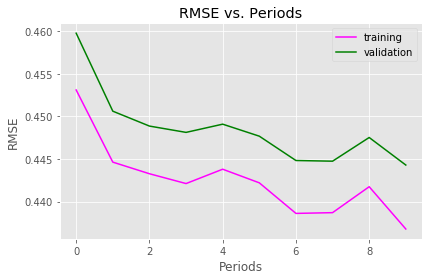

In [8]:
linear_regressor = train_linear_regressor_model(
    learning_rate = 0.000001,
    steps = 200,
    batch_size = 20,
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets
)

### Obtain Prediciton values to compute LogLoss

[0.08860067 0.14984149 0.02666155 ... 0.01994595 0.11841194 0.07760213]


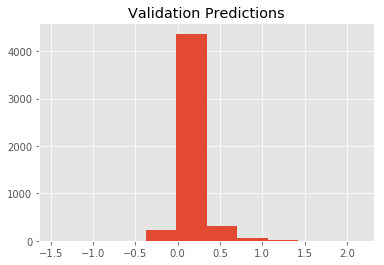

In [9]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                                   validation_targets["median_house_value_is_high"],
                                                   shuffle=False,
                                                   num_epochs=1)
validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
print(validation_predictions)
plt.title("Validation Predictions")
_ = plt.hist(validation_predictions)

### Train a Logistic Regression model and calculate LogLoss on Validation set

In [10]:
def train_linear_classifier_model(learning_rate,
                                  steps,
                                  batch_size,
                                  training_examples,
                                  training_targets,
                                  validation_examples,
                                  validation_targets):
    periods = 10
    steps_per_period = steps / periods
    
    # Create linear_classifer object
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_classifier = tf.estimator.LinearClassifier(
        feature_columns = construct_feature_columns(training_examples),
        optimizer = my_optimizer
    )
    
    # Create input functions
    training_input_fn = lambda: my_input_fn(training_examples,
                                            training_targets["median_house_value_is_high"],
                                            batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples,
                                                    training_targets["median_house_value_is_high"],
                                                    shuffle=False,
                                                    num_epochs=1)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                                      validation_targets["median_house_value_is_high"],
                                                      shuffle=False,
                                                      num_epochs=1)
    
    # Train the model in loop
    print("Training model...")
    print("  LogLoss (on training data):")
    training_log_losses = []
    validation_log_losses = []
    for period in range(0, periods):
        linear_classifier.train(
            input_fn = training_input_fn,
            steps = steps_per_period
        )
        
        # Predictions
        training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
        validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
        validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
        
        training_log_loss = metrics.log_loss(training_targets,
                                             training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets,
                                               validation_probabilities)
        print("    Period %02d : %0.2f\t%0.2f" % (period+1,
                                                  training_log_loss,
                                                  validation_log_loss))
        training_log_losses.append(training_log_loss)
        validation_log_losses.append(validation_log_loss)
    print("Model training finished.")
    
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label="training", color="magenta")
    plt.plot(validation_log_losses, label="validation", color="g")
    plt.legend()
    return linear_classifier

Training model...
  LogLoss (on training data):
    Period 01 : 0.60	0.61
    Period 02 : 0.57	0.58
    Period 03 : 0.57	0.57
    Period 04 : 0.55	0.57
    Period 05 : 0.54	0.55
    Period 06 : 0.54	0.56
    Period 07 : 0.53	0.54
    Period 08 : 0.53	0.54
    Period 09 : 0.52	0.54
    Period 10 : 0.52	0.54
Model training finished.


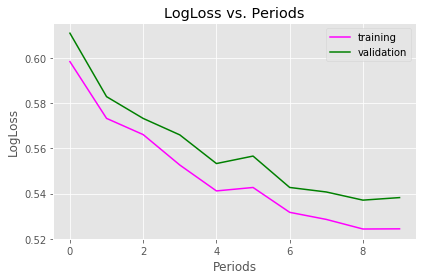

In [11]:
linear_classifier = train_linear_classifier_model(
    learning_rate = 0.000005,
    steps = 500,
    batch_size = 20,
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets
)

### Accuracy and ROC for Validation set

In [12]:
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)
print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

AUC on the validation set: 0.72
Accuracy on the validation set: 0.75


[0.25986293 0.11559922 0.00820008 ... 0.11791386 0.35810488 0.21198724] 

[0.00000000e+00 2.68744961e-04 2.41870465e-03 ... 9.97312550e-01
 9.97312550e-01 1.00000000e+00] 

[0.         0.         0.         ... 0.99921814 1.         1.        ] 

[1.9990857e+00 9.9908566e-01 9.4320416e-01 ... 4.1110849e-05 3.8102851e-05
 3.2629078e-27]


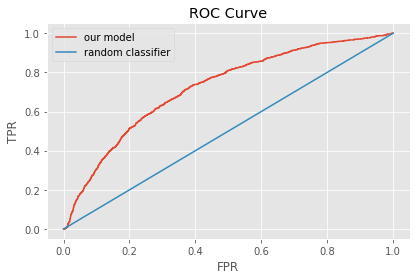

In [13]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])
print(validation_probabilities,"\n")

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets,validation_probabilities)
print(false_positive_rate,"\n")
print(true_positive_rate,"\n")
print(thresholds)

plt.ylabel("TPR")
plt.xlabel("FPR")
plt.title("ROC Curve")
plt.tight_layout()
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
plt.legend()
plt.show()

### Retraining and Graphing ROC

Training model...
  LogLoss (on training data):
    Period 01 : 0.50	0.51
    Period 02 : 0.49	0.50
    Period 03 : 0.48	0.49
    Period 04 : 0.47	0.48
    Period 05 : 0.47	0.48
    Period 06 : 0.47	0.48
    Period 07 : 0.47	0.48
    Period 08 : 0.47	0.48
    Period 09 : 0.46	0.48
    Period 10 : 0.46	0.47
Model training finished.


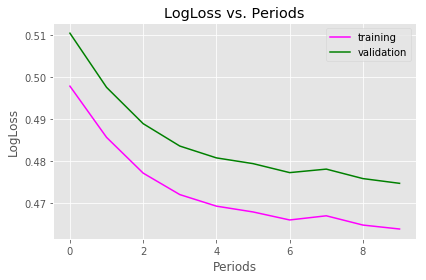

In [14]:
linear_classifier = train_linear_classifier_model(
    learning_rate = 0.000003,
    steps = 20000,
    batch_size = 500,
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets
)

In [15]:
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)
print(evaluation_metrics,"\n")
print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

{'accuracy': 0.7758, 'accuracy_baseline': 0.7442, 'auc': 0.80278903, 'auc_precision_recall': 0.5733107, 'average_loss': 0.4747497, 'label/mean': 0.2558, 'loss': 0.4747497, 'prediction/mean': 0.25263765, 'global_step': 20000} 

AUC on the validation set: 0.80
Accuracy on the validation set: 0.78


[0.17037702 0.1216086  0.00235404 ... 0.05628114 0.33003324 0.05503871] 

[0.00000000e+00 2.68744961e-04 2.68744961e-04 ... 9.96237571e-01
 9.96237571e-01 1.00000000e+00] 

[0.         0.         0.00234558 ... 0.99921814 1.         1.        ] 

[1.9948502e+00 9.9485022e-01 9.8775601e-01 ... 1.1893142e-05 1.1688666e-05
 8.0326084e-34]


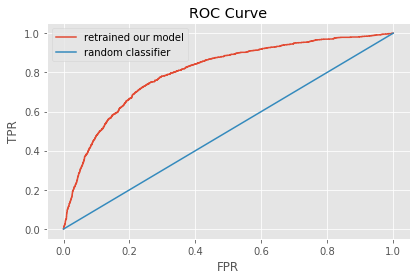

In [16]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])
print(validation_probabilities,"\n")

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
print(false_positive_rate,"\n")
print(true_positive_rate,"\n")
print(thresholds)

plt.ylabel("TPR")
plt.xlabel("FPR")
plt.title("ROC Curve")
plt.tight_layout()
plt.plot(false_positive_rate, true_positive_rate, label="retrained our model")
plt.plot([0, 1], [0, 1], label="random classifier")
plt.legend()
plt.show()

### Some tracing with Predictions

In [18]:
validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item for item in validation_predictions])
print(validation_predictions)

[{'predictions': array([0.08860067], dtype=float32)}
 {'predictions': array([0.14984149], dtype=float32)}
 {'predictions': array([0.02666155], dtype=float32)} ...
 {'predictions': array([0.01994595], dtype=float32)}
 {'predictions': array([0.11841194], dtype=float32)}
 {'predictions': array([0.07760213], dtype=float32)}]
